In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

plt.style.use('dark_background')

from tensorflow.keras.models import Model

def visualize_layer_outputs(model, image, n):
    """
    Pass an image through the first `n` layers of the model and plot output channels.

    Parameters:
    - model: Keras Sequential model
    - image: single input image (shape must match model input)
    - n: number of layers to include
    """
    # Ensure image has batch dimension
    if image.ndim == 3:
        image = np.expand_dims(image, axis=0)
    
    # Create a model up to the nth layer
    truncated_model = Model(inputs=model.inputs, outputs=model.layers[n].output)

    # Get activations
    activations = truncated_model.predict(image)
    
    # Squeeze batch dimension if needed
    if activations.ndim == 4:
        activations = np.squeeze(activations, axis=0)  # shape: (H, W, C)

    n_channels = activations.shape[-1]

    # Set up subplot grid
    n_cols = 4
    n_rows = int(np.ceil((n_channels + 1) / n_cols))  # +1 for original image
    size = 4
    
    plt.figure(figsize=(size * n_cols, size * n_rows))

    # Plot original image
    plt.subplot(n_rows, n_cols, 1)
    if image.shape[-1] == 1:
        plt.imshow(image[0, ..., 0], cmap='gray')
    else:
        plt.imshow(image[0])
    plt.title("Original")

    # Plot each channel
    for i in range(n_channels):
        plt.subplot(n_rows, n_cols, i + 2)
        plt.imshow(activations[..., i], cmap='gray', interpolation=None)
        plt.title(f"Channel {i}")

    plt.tight_layout()
    plt.show()

# Keras CNN on un-augmented MNIST data

In [4]:
from tensorflow.keras.datasets import mnist

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

# Print shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (60000, 28, 28, 1)
X_test.shape:  (10000, 28, 28, 1)


## Create/train/analyze model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

dropout_rate = 0.1

n_classes  = np.unique(y_train).shape[0]

# Create model
model = Sequential([
    Input(shape=X_train.shape[1:]),
    
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),
    BatchNormalization(),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),
    
    GlobalAveragePooling2D(),
    
    Dense(32, activation='relu'),
    Dropout(dropout_rate),
    Dense(16, activation='relu'),
    
    Dense(n_classes, activation='softmax'),
])

# Display model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,618 (25.85 KB)

 Trainable params: 6,586 (25.73 KB)

 Non-trainable params: 32 (128.00 B)

In [12]:
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.01)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=512,
    shuffle=True,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7024 - loss: 42.5657 - val_accuracy: 0.8783 - val_loss: 2.4840
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8579 - loss: 1.7228 - val_accuracy: 0.8557 - val_loss: 0.6694
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8651 - loss: 0.5374 - val_accuracy: 0.8917 - val_loss: 0.3672
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8955 - loss: 0.3613 - val_accuracy: 0.8989 - val_loss: 0.3402
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8980 - loss: 0.3469 - val_accuracy: 0.9052 - val_loss: 0.3289
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9054 - loss: 0.3138 - val_accuracy: 0.9051 - val_loss: 0.3221
Epoch 7/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9043 - loss: 0.3259 - val_accuracy: 0.9077 - val_loss: 0.3142
Epoch 8/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9103 - loss: 0.3085 - val_accuracy: 0

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


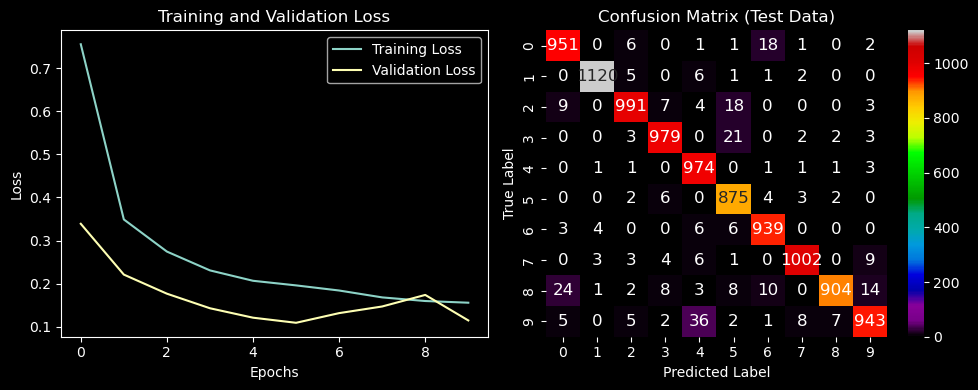

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.94      0.99      0.97       982
           5       0.94      0.98      0.96       892
           6       0.96      0.98      0.97       958
           7       0.98      0.97      0.98      1028
           8       0.99      0.93      0.96       974
           9       0.97      0.93      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_test_pred  = model.predict(X_test).argmax(axis=1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Training and Validation Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
#axes[0].set_yscale('log')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Right subplot: Confusion Matrix (Test Data) using seaborn heatmap with vmin set to 0
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1].set_title('Confusion Matrix (Test Data)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print classification report for test data
report = classification_report(y_test, y_test_pred)
print(report)

## Visualize channels after processing

In [7]:
idx = np.random.choice( range(X_train.shape[0]), 1 )[0]

# Choose an image from your dataset
sample_img = X_train[idx]  # or any image shaped like your input

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


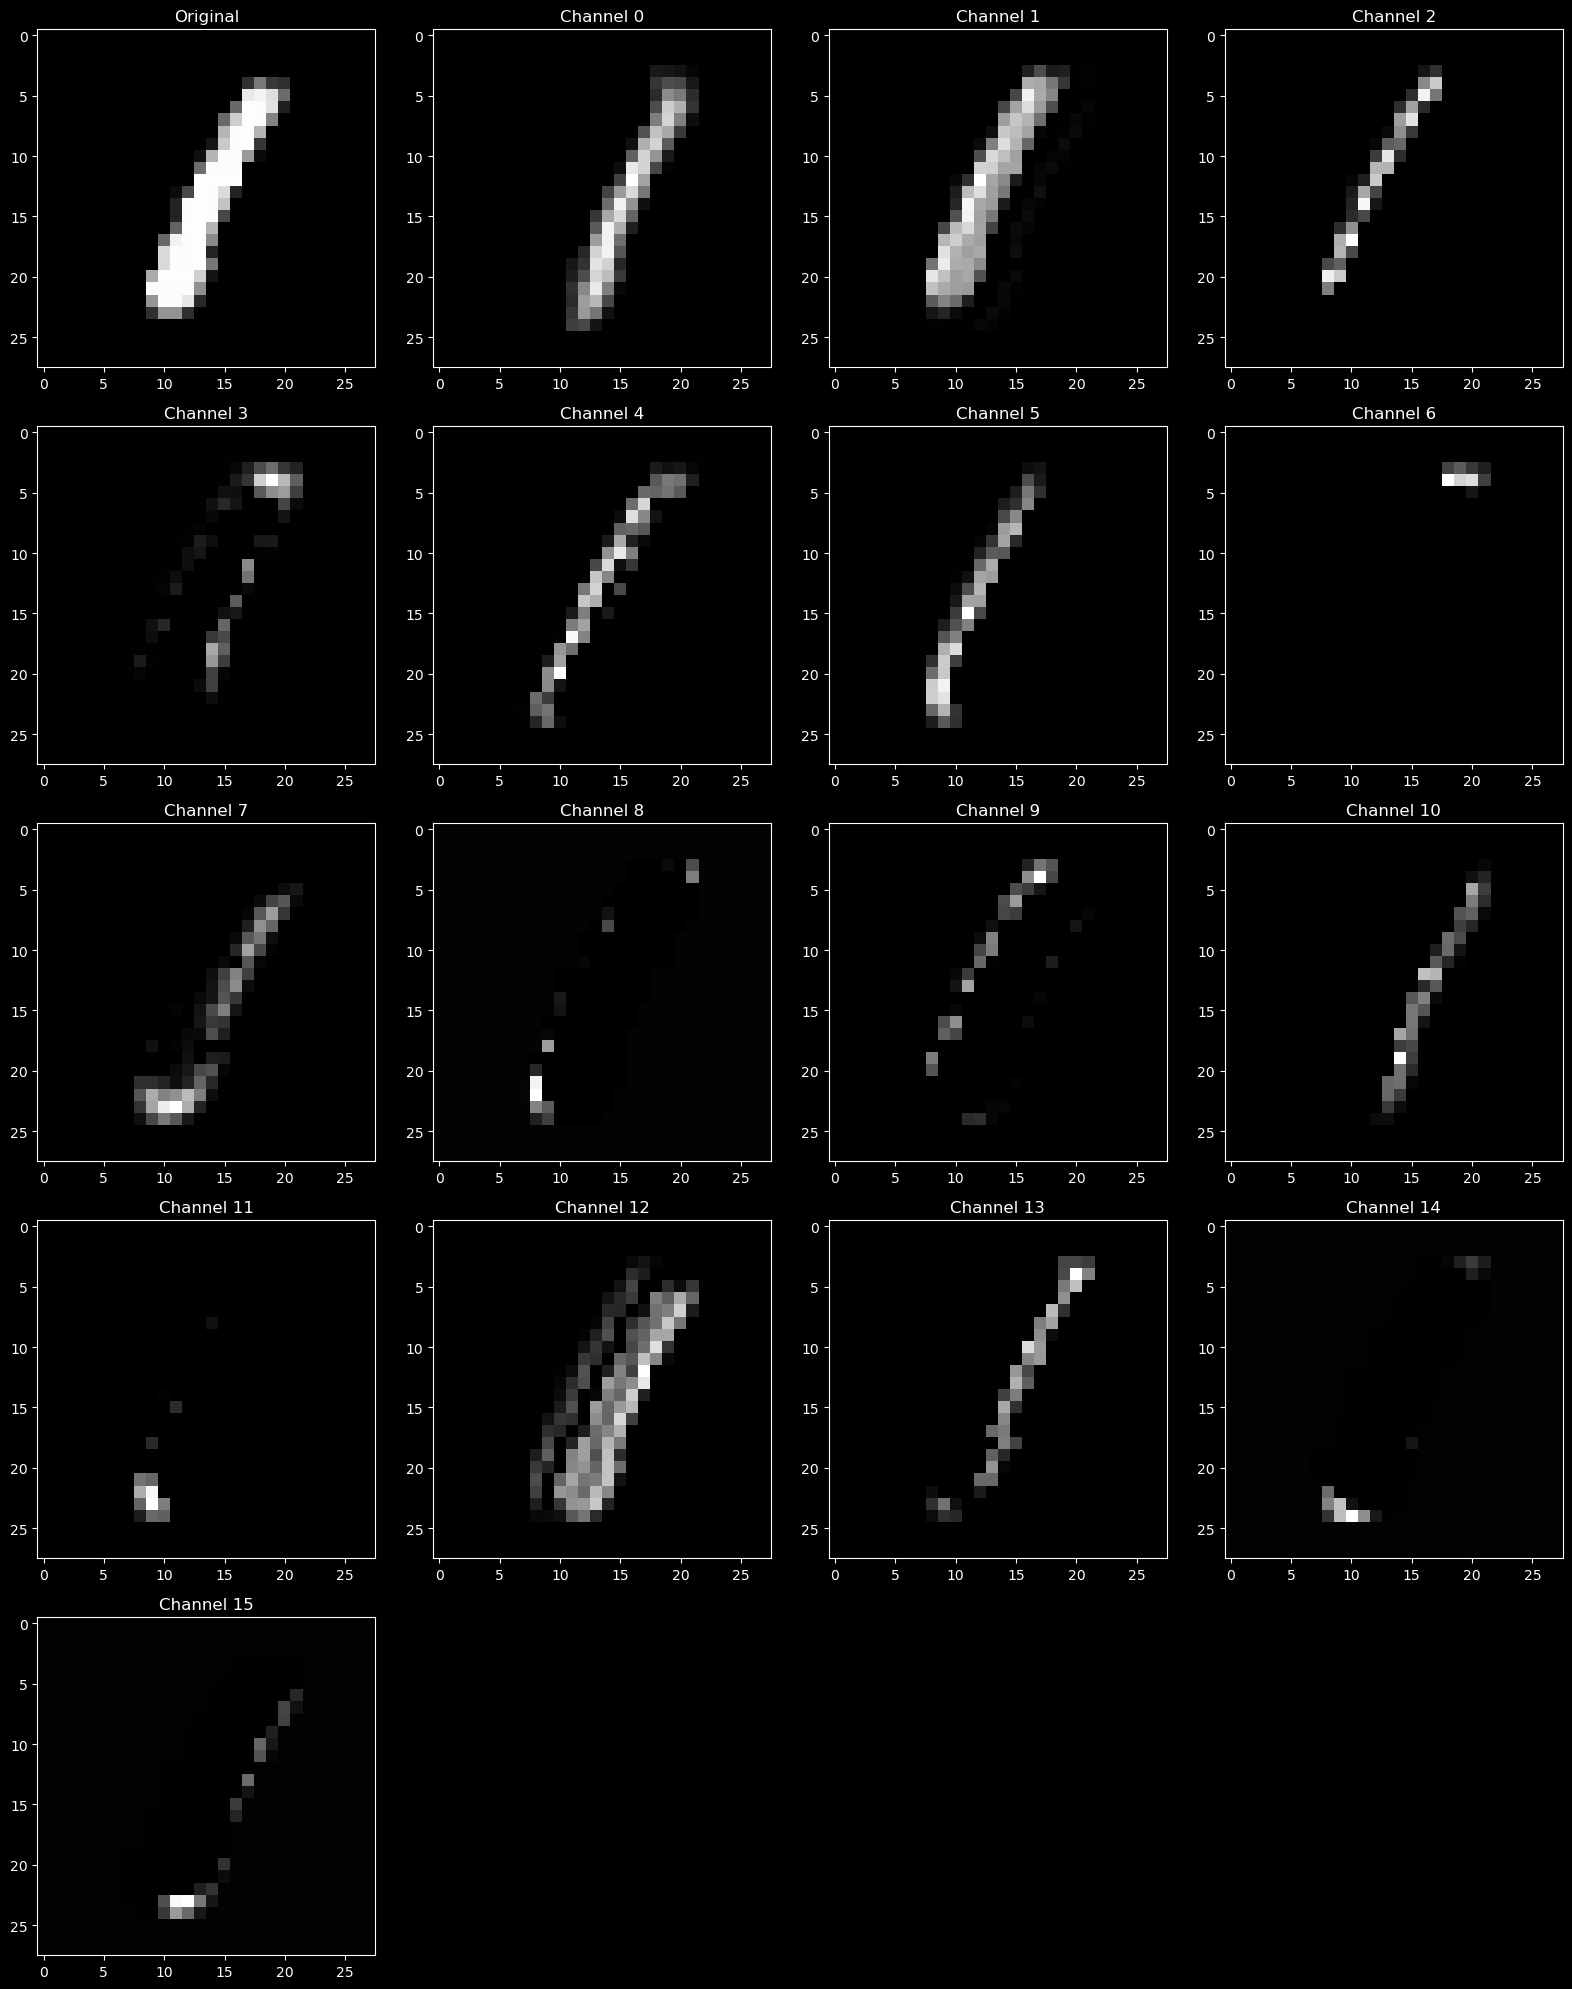

In [9]:
# Visualize up to the 2nd Conv2D layer (index 2)
visualize_layer_outputs(model, sample_img, n=0)

# Keras CNN on augmented MNIST data

In [15]:
from tensorflow.keras.datasets import mnist

# Load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 28, 28, 1)
X_test  = X_test.reshape(-1, 28, 28, 1)

# Print shapes
print("X_train.shape:", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape: (60000, 28, 28, 1)
X_test.shape:  (10000, 28, 28, 1)


## Create/train/analyze model

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

dropout_rate = 0.2

n_classes  = np.unique(y_train).shape[0]

# Create model
model = Sequential([
    Input(shape=X_train.shape[1:]),
    
    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),
    BatchNormalization(),
    
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),
    BatchNormalization(),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    
    GlobalAveragePooling2D(),
    
    Dense(32, activation='relu'),
    Dropout(dropout_rate),
    Dense(16, activation='relu'),
    
    Dense(n_classes, activation='softmax'),
])

# Display model summary
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)                   │ (None, 28, 28, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 14, 14, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 14, 14, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 7, 7, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 7, 7, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_13          │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,738 (30.23 KB)

 Trainable params: 7,690 (30.04 KB)

 Non-trainable params: 48 (192.00 B)

In [51]:
# Define the optimizer with a custom learning rate
optimizer = Adam(learning_rate=0.01)

# Compile model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=25,          # Stop after 5 epochs without improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the image generator with augmentation options
datagen = ImageDataGenerator(
    rotation_range=10,      # Rotate images randomly
    width_shift_range=0.1,  # Randomly shift the width of images
    height_shift_range=0.1, # Randomly shift the height of images
    zoom_range=0.1,         # Randomly zoom
)

In [53]:
history = model.fit(
    datagen.flow(
        X_train, y_train,
        batch_size=512,
        shuffle=True,
        ),
    epochs=5,
    validation_data=datagen.flow(
        X_test, y_test
        ),
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.4845 - loss: 1.4206 - val_accuracy: 0.7148 - val_loss: 0.8512
Epoch 2/5
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.8895 - loss: 0.3531 - val_accuracy: 0.9514 - val_loss: 0.1640
Epoch 3/5
 38/118 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.9343 - loss: 0.2228

KeyboardInterrupt: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


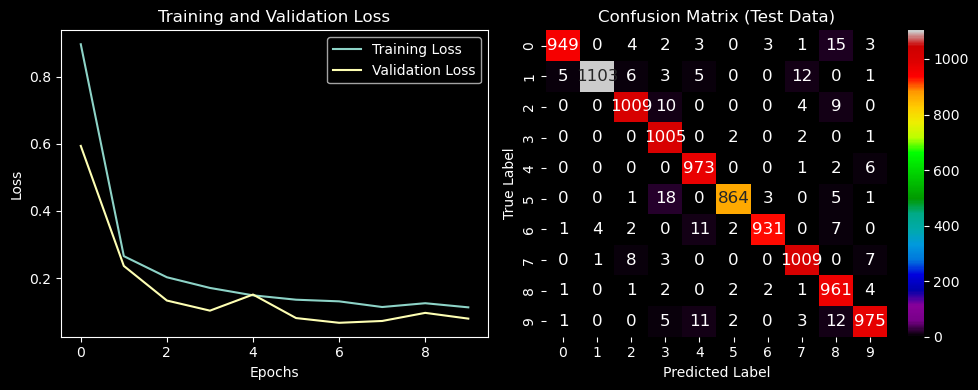

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       1.00      0.97      0.98      1135
           2       0.98      0.98      0.98      1032
           3       0.96      1.00      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.97      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.95      0.99      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_test_pred  = model.predict(X_test).argmax(axis=1)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Training and Validation Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
#axes[0].set_yscale('log')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Right subplot: Confusion Matrix (Test Data) using seaborn heatmap with vmin set to 0
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1], vmin=0, 
            annot_kws={"size": 12}, cmap='nipy_spectral')
axes[1].set_title('Confusion Matrix (Test Data)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Print classification report for test data
report = classification_report(y_test, y_test_pred)
print(report)

## Visualize channels after processing

In [57]:
idx = np.random.choice( range(X_train.shape[0]), 1 )[0]

# Choose an image from your dataset
sample_img = X_train[idx]  # or" any image shaped like your input

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


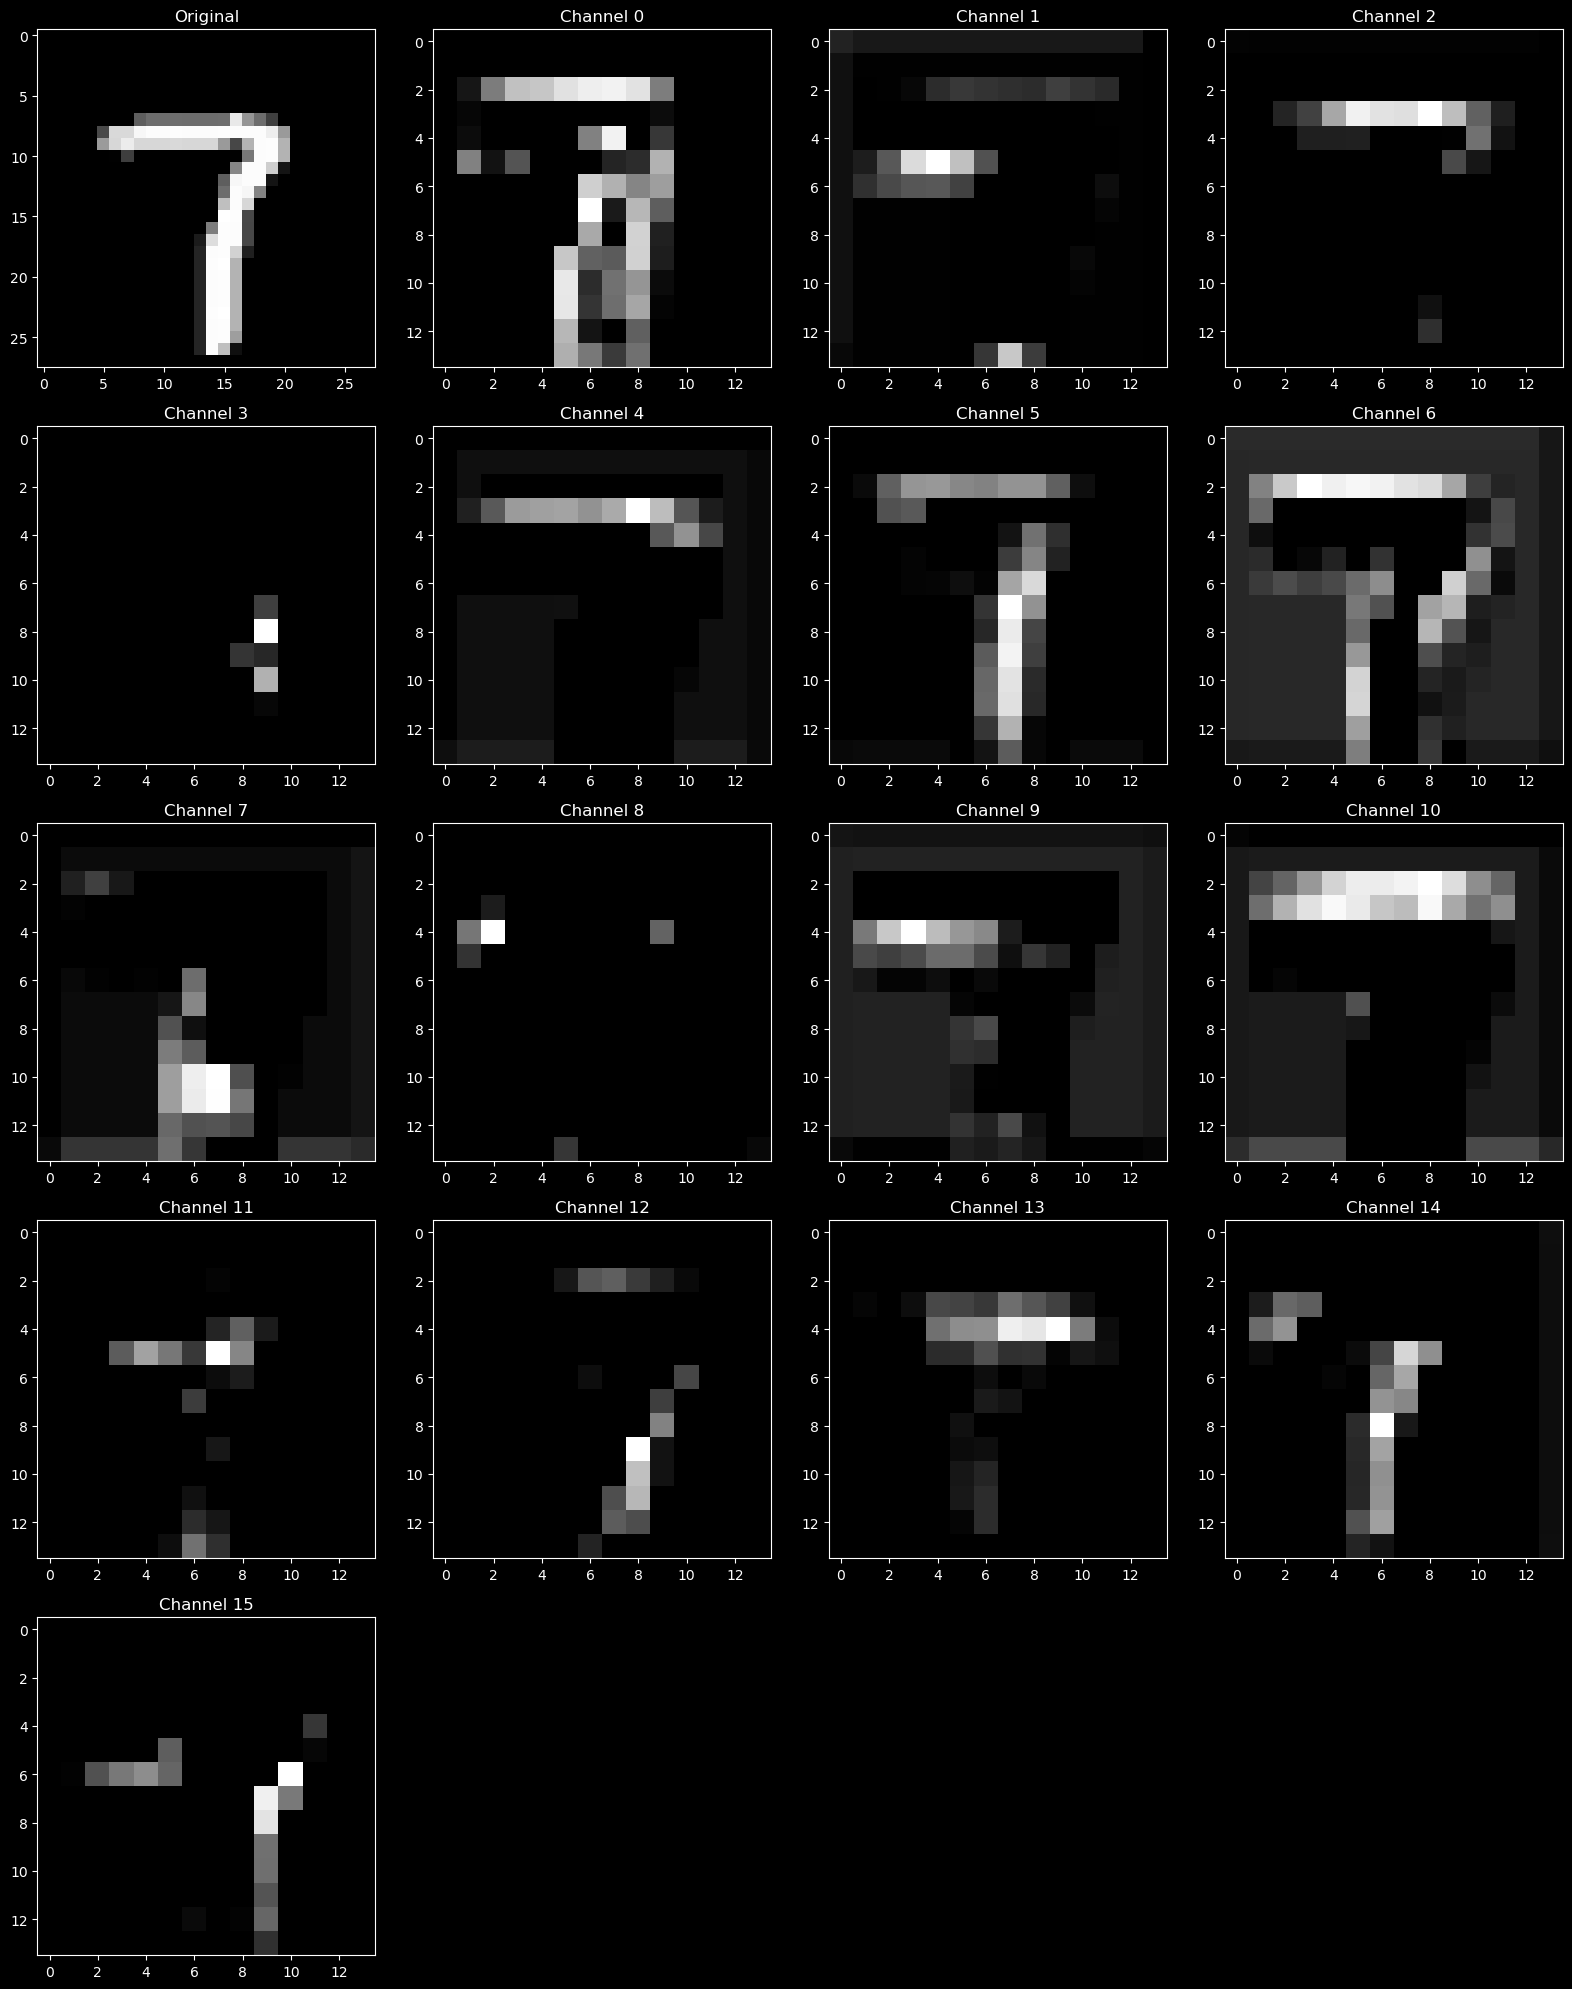

In [59]:
# Visualize up to the 2nd Conv2D layer (index 2)
visualize_layer_outputs(model, sample_img, n=3)